In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/WaterDamage_STADS2023


/content/drive/MyDrive/WaterDamage_STADS2023


In [25]:
!pip install pytorch_lightning
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.4 MB/s eta 0:00:00


{'segmentation': [[0.10248774509803922, 0.8164256198347107, 0.14248774509803921, 0.771797520661157, 0.1699387254901961, 0.7470041322314049, 0.1840563725490196, 0.7321280991735537, 0.2020955882352941, 0.7122933884297521, 0.25542892156862745, 0.7106404958677686, 0.2891544117647059, 0.6941115702479339, 0.31974264705882355, 0.6693181818181818, 0.341703431372549, 0.6676652892561984, 0.37464460784313725, 0.6875, 0.3997426470588235, 0.7023760330578512, 0.421703431372549, 0.7271694214876033, 0.4711151960784314, 0.7288223140495868, 0.47425245098039215, 0.6792355371900827, 0.5158210784313726, 0.6825413223140496, 0.5236642156862745, 0.6941115702479339, 0.5401348039215687, 0.7172520661157025, 0.5581740196078432, 0.7089876033057851, 0.5597426470588235, 0.6825413223140496, 0.5832720588235294, 0.7106404958677686, 0.6138602941176471, 0.7222107438016528, 0.6334681372549019, 0.7205578512396694, 0.669546568627451, 0.7007231404958678, 0.673468137254902, 0.6808884297520661, 0.6820955882352941, 0.6346074380

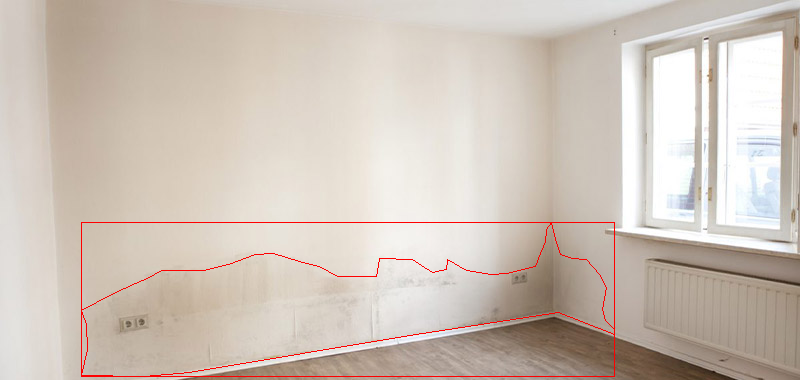

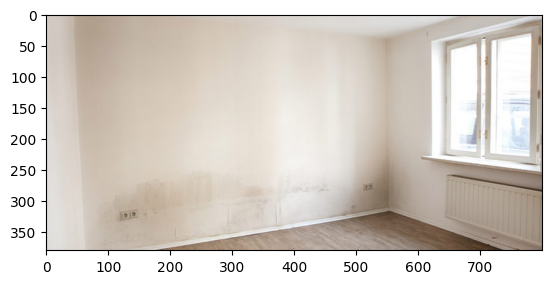

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import json


image_path = "Bilder/ID_40.jpg"
image = Image.open(image_path)

fig, ax = plt.subplots()

ax.imshow(image)


annotation_path = "WD_1-100_segmentation.json"
# Read json
with open(annotation_path, "r") as f:
    annotations = json.load(f)
print(annotations['annotations'][0])

width, height = image.size
segmentation = annotations['annotations'][0]['segmentation'][0]
bbox_x1 = annotations['annotations'][0]['bbox'][0] * width
bbox_y1 = annotations['annotations'][0]['bbox'][1] * height
bbox_width = annotations['annotations'][0]['bbox'][2] * width + bbox_x1
bbox_height = annotations['annotations'][0]['bbox'][3] * height + bbox_y1
bbox = [bbox_x1, bbox_y1, bbox_width, bbox_height]

print(bbox)
print(width, height)
# width, height = annotations['images'][0]['width'], annotations['images'][0]['height']
scaled_segmentation = []
for i in range(0, len(segmentation), 2):
    x = int(segmentation[i] * width)
    y = int(segmentation[i+1] * height)
    scaled_segmentation.append((x, y))

# Draw the segmentation on the image
draw = ImageDraw.Draw(image)
draw.polygon(scaled_segmentation, outline="red")
draw.rectangle(bbox, outline="red")
image.show()


# Show the plot
plt.show()


In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

import multiprocessing as mp
mp.set_start_method('spawn', force=True)


Using device: cuda


In [10]:

import torchvision.transforms.functional as Func
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
import os
from PIL import Image, ImageDraw

class WaterDamageDataset(torch.utils.data.Dataset):
    def __init__(self, root, ann_file, img_size=(256, 256), transforms=None, flag=False):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.img_size = img_size

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name'].split('/')[-1]

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        
        img = img.resize(self.img_size)

        width, height = img.size

        mask = np.zeros((height, width), dtype=np.uint8)
        for ann in anns:
            segmentation = ann['segmentation'][0]
            bbox_x1 = ann['bbox'][0] * width
            bbox_y1 = ann['bbox'][1] * height
            bbox_width = ann['bbox'][2] * width + bbox_x1
            bbox_height = ann['bbox'][3] * height + bbox_y1
            bbox = [bbox_x1, bbox_y1, bbox_width, bbox_height]

            scaled_segmentation = []
            for i in range(0, len(segmentation), 2):
                x = int(segmentation[i] * width)
                y = int(segmentation[i+1] * height)
                scaled_segmentation.append(x)
                scaled_segmentation.append(y)

            if isinstance(segmentation, list):
                rles = maskUtils.frPyObjects([scaled_segmentation], height, width)
                rle = maskUtils.merge(rles)
            elif type(segmentation['counts']) == list:
                rle = maskUtils.frPyObjects([scaled_segmentation], height, width)
            else:
                rle = ann['segmentation']
            mask = np.where(mask > 1, 1, 0)
            mask = maskUtils.decode(rle)
            transform = transforms.ToTensor()
            img_tensor = transform(img).to(device)
            mask_tensor = transform(mask).to(device)
            return img_tensor, mask_tensor

        # apply mask to image
        img = Image.fromarray(np.uint8(img * mask))
        return img
        

    def __len__(self):
        return len(self.ids)



In [12]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class AugmentedWaterDamageDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset 
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomAdjustSharpness(0.5),
            transforms.ToTensor()
         ])

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        img, mask = self.original_dataset[index]
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask


In [40]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as Func

import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as Func
from torchvision import transforms
class WaterDamageDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        
        self.data_dir = "Bilder"    
        self.json_file = "WD_1-100_segmentation.json"

        self.batch_size = 10
        self.num_workers = 0
        self.img_size = 256
        self.train_val_split = 0.8
        self.val_test_split = 0.5

    def prepare_data(self):
        pass
    
    def setup(self, stage=None):
        original_dataset = WaterDamageDataset(self.data_dir, self.json_file)
        augmented_dataset = AugmentedWaterDamageDataset(original_dataset)
        num_samples = len(augmented_dataset)
        
        train_val_size = int(self.train_val_split * num_samples)
        val_test_size = int((1 - self.train_val_split) * self.val_test_split * num_samples)
        test_size = num_samples - train_val_size - val_test_size

        train_val_dataset, test_dataset = random_split(augmented_dataset, [train_val_size, val_test_size + test_size])
        train_size = int(self.train_val_split * train_val_size)
        self.train_dataset, self.val_dataset = random_split(train_val_dataset, [train_size, train_val_size - train_size])
        
        self.test_dataset = test_dataset  
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False
        )

    def transforms(self, img, mask):
        transform = transforms.Compose([transforms.Resize(self.img_size),
                                        transforms.ToTensor()])
        img_tensor = transform(img)
        mask_tensor = transform(mask)
        return img_tensor, mask_tensor

In [19]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
import os
import dill as pickle
import torchvision.transforms.functional as TF
import os

class Block(pl.LightningModule):
    
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)

In [18]:
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.8 MB/s eta 0:00:00


In [20]:
class Encoder(pl.LightningModule):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            Block(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


In [21]:
class Decoder(pl.LightningModule):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = Block(in_channels, out_channels)

    def forward(self, expand_input, contract_input):
        expand_output = self.up(expand_input)
        if expand_output.shape != contract_input.shape:
                expand_output = TF.resize(expand_output, size=contract_input.shape[2:])
        concat_output = torch.cat((expand_output, contract_input), dim=1)
        return self.conv(concat_output)

In [22]:
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

class UNet(pl.LightningModule):

    def __init__(self, chn=(3,64,128,256,512, 1024)):
        super().__init__()
        self.learning_rate = 1e-3 #1e-3

        self.train_pixel_acc = torchmetrics.classification.BinaryAccuracy(num_classes=2, ignore= 255, average='weighted')
        self.train_J = torchmetrics.classification.BinaryJaccardIndex(num_classes=2, ignore= 255, average='weighted')

        self.val_pixel_acc = torchmetrics.classification.BinaryAccuracy(num_classes=2, ignore= 255 , average='weighted')
        self.val_J = torchmetrics.classification.BinaryJaccardIndex(num_classes=2, ignore= 255 , average='weighted')

        self.test_pixel_acc = torchmetrics.classification.BinaryAccuracy(num_classes=2, ignore= 255, average='weighted')
        self.test_J = torchmetrics.classification.BinaryJaccardIndex(num_classes=2, ignore= 255, average='weighted')      

        self.first_layer = Block(chn[0], chn[1])
        self.encode_layers = nn.ModuleList()
        self.decode_layers = nn.ModuleList()
        
        for i in range(1, len(chn)-2):
            self.encode_layers.append(Encoder(chn[i],chn[i+1]))

        self.bottleneck = Block(chn[-2], chn[-1])

                    
        for i in range(len(chn)-1, 1, -1):
            self.decode_layers.append(Decoder(chn[i], chn[i-1]))
            
        self.final_layer = nn.Conv2d(chn[1], 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

   

    def forward(self, x):
        x = self.first_layer(x)
        connections = []
        connections.append(x)
        for encode_layer in self.encode_layers:
            x = encode_layer(x)
            connections.append(x)
            
        x = self.bottleneck(x)
        connections = connections[::-1]

        for i in range(len(self.decode_layers)):
            x = self.decode_layers[i](x, connections[i])
                           
        return self.sigmoid(self.final_layer(x))

    def decode_segmap(self, prediction):
        label_colors = torch.tensor([(0, 64, 128)])
        r = torch.zeros_like(prediction, dtype=torch.uint8)
        g = torch.zeros_like(prediction, dtype=torch.uint8)
        b = torch.zeros_like(prediction, dtype=torch.uint8)
        for l in range(0, self.num_class):
            idx = prediction == l
            r[idx] = label_colors[l, 0]
            g[idx] = label_colors[l, 1]
            b[idx] = label_colors[l, 2]
        rgb = torch.stack([r, g, b], axis=1)
        return rgb

    def training_step(self, train_batch, batch_idx):
        images, seg_mask = train_batch

        # convert the non-binary seg_mask to binary
        seg_mask_binary = torch.where(seg_mask > 0, torch.tensor(1), torch.tensor(0))
        seg_mask_binary = seg_mask_binary.squeeze(1).to(device)
        outputs = self(images)
        pred_seg_mask = torch.argmax(outputs, 1).to(device)
        outputs = outputs.squeeze(1).to(device)
        pred_seg_mask = pred_seg_mask.squeeze(1).to(device)
        # pixel-wise accuracy
        self.train_pixel_acc(pred_seg_mask, seg_mask_binary)

        # the Jaccard index (mean IoU)
        self.train_J(pred_seg_mask, seg_mask_binary)
        
        self.log('train_acc', self.train_pixel_acc, on_step=False, on_epoch=True)
        self.log('train_mIoU', self.train_J, on_step=False, on_epoch=True)

        # convert seg_mask_binary to float
        seg_mask_binary = seg_mask_binary.float()

        # loss
        loss = F.binary_cross_entropy(outputs.squeeze(1).to(device), seg_mask_binary.float())
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        print("Train :", loss, self.train_pixel_acc)
        return loss



    def validation_step(self, val_batch, batch_idx):
      images, seg_mask = val_batch

      seg_mask_binary = torch.where(seg_mask > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device))
      seg_mask_binary = seg_mask_binary.squeeze(1).to(device)
      outputs = self(images)
      pred_seg_mask = torch.argmax(outputs, 1)
      outputs = outputs.squeeze(1).to(device)
      pred_seg_mask = pred_seg_mask.squeeze(1).to(device)
      print(outputs.shape, pred_seg_mask.shape, seg_mask_binary.shape)
      # pixel-wise accuracy
      self.val_pixel_acc(pred_seg_mask, seg_mask_binary)

      # the Jaccard index (mean IoU)
      self.val_J(pred_seg_mask, seg_mask_binary)

      self.log('val_pixel_acc', self.val_pixel_acc, on_step=False, on_epoch=True)
      # self.log('val_mIoU', self.val_J, on_step=False, on_epoch=True)
      print("Valid:",  self.val_pixel_acc, self.val_J)
      loss = F.binary_cross_entropy(outputs.squeeze(1).to(device), seg_mask_binary.float())
      self.log('valid_loss', loss, on_step=False, on_epoch=True)
      return loss



    def test_step(self, batch, batch_idx):
      images, seg_mask = batch

      seg_mask_binary = torch.where(seg_mask > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device))
      seg_mask_binary = seg_mask_binary.squeeze(1).to(device)

      outputs = self(images)
      pred_seg_mask = torch.argmax(outputs, 1)
      outputs = outputs.squeeze(1).to(device)
      pred_seg_mask = pred_seg_mask.squeeze(1).to(device)
      print(outputs.shape, pred_seg_mask.shape, seg_mask_binary.shape)
      self.test_pixel_acc(pred_seg_mask, seg_mask_binary)
      self.test_J(pred_seg_mask, seg_mask_binary)
      print("Test:",  self.test_pixel_acc, self.val_J)
      self.log("test_acc", self.test_pixel_acc)
      # self.log("test_mIoU", self.test_J)

      loss = F.binary_cross_entropy(outputs.squeeze(1), seg_mask_binary.float())
      self.log('test_loss', loss, on_step=False, on_epoch=True)
      return loss
        

    def configure_optimizers(self):
        opt = torch.optim.SGD(self.parameters(), lr = self.learning_rate)
        return opt

In [23]:
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime as dt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

NAME = "UNet_" + dt.now().strftime("%m_%d_%Y__%H_%M_%S")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step') 

checkpoint = ModelCheckpoint(
    dirpath='models',
    save_top_k=1,
    verbose=True,
    monitor='val_pixel_acc',
    mode='max',
    filename=NAME+'_{epoch}-{val_mIoU:.2f}'#NAME
)

early_stopping = EarlyStopping(
   monitor='val_pixel_acc',
   patience=60,
   verbose=True,
   mode='max'
)


In [36]:
waterdamage_data_module = WaterDamageDataModule()
logger = pl.loggers.TensorBoardLogger("unet", name="water_damage_detection")

model = UNet()
trainer = pl.Trainer(
    logger=logger,
    max_epochs=500,
    log_every_n_steps=1,
    callbacks=[lr_monitor, checkpoint, early_stopping],
)

trainer.fit(model, waterdamage_data_module)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/drive/MyDrive/WaterDamage_STADS2023/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type               | Params
--------------------------------------------------------
0  | train_pixel_acc | BinaryAccuracy     | 0     
1  | train_J         | BinaryJaccardIndex | 0     
2  | val_pixel_acc   | BinaryAccuracy     | 0     
3  | val_J           | BinaryJaccardIndex | 0     
4  | test_pixel_acc  | BinaryAccuracy     | 0     
5  | test_J          | BinaryJaccardIndex | 0     
6  | first_layer     | Block              | 38.8 K
7  | encode_layers   | ModuleList         | 4.6 M 
8  | decode_layers   | ModuleList         | 12.2 M
9  | bottleneck      | Block              | 14.2 M
10 | final_layer     | Conv2d             | 65    
11 | sigmoid         | Sigmoid            | 0     
--------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.151   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


Training: 0it [00:00, ?it/s]

Train : tensor(0.6623, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6675, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_pixel_acc improved. New best score: 0.799
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 7: 'val_pixel_acc' reached 0.79927 (best 0.79927), saving model to '/content/drive/MyDrive/WaterDamage_STADS2023/models/UNet_05_05_2023__08_40_42_epoch=0-val_mIoU=0.00.ckpt' as top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_pixel_acc improved by 0.118 >= min_delta = 0.0. New best score: 0.917
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 14: 'val_pixel_acc' reached 0.91733 (best 0.91733), saving model to '/content/drive/MyDrive/WaterDamage_STADS2023/models/UNet_05_05_2023__08_40_42_epoch=1-val_mIoU=0.00.ckpt' as top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 21: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 28: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 35: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 42: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5751, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 49: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_pixel_acc improved by 0.058 >= min_delta = 0.0. New best score: 0.975
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 56: 'val_pixel_acc' reached 0.97487 (best 0.97487), saving model to '/content/drive/MyDrive/WaterDamage_STADS2023/models/UNet_05_05_2023__08_40_42_epoch=7-val_mIoU=0.00.ckpt' as top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 63: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 70: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 77: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5658, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 84: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 91: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 98: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 105: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 112: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 119: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 126: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 133: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 140: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4722, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 147: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 154: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4575, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 161: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 168: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 175: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 182: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 189: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 196: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 203: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 210: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 217: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 224: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 231: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5612, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5428, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 238: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 245: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 252: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 259: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 266: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 273: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_pixel_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.975
INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 280: 'val_pixel_acc' reached 0.97507 (best 0.97507), saving model to '/content/drive/MyDrive/WaterDamage_STADS2023/models/UNet_05_05_2023__08_40_42_epoch=39-val_mIoU=0.00.ckpt' as top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 287: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 294: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 301: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 308: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 315: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 322: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 329: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 336: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 343: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.8326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 350: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 357: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 364: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 371: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 378: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 385: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 392: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 399: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 406: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 413: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 420: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 427: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 434: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3613, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 441: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 448: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 455: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 462: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 469: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5586, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 476: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 483: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 490: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 497: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 504: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 511: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 518: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_pixel_acc improved by 0.018 >= min_delta = 0.0. New best score: 0.994
INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 525: 'val_pixel_acc' reached 0.99352 (best 0.99352), saving model to '/content/drive/MyDrive/WaterDamage_STADS2023/models/UNet_05_05_2023__08_40_42_epoch=74-val_mIoU=0.00.ckpt' as top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4586, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 532: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 539: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 546: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 553: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4577, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 560: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 567: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 574: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 581: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 588: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 595: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4723, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 602: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 609: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 616: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 623: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 630: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 637: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 644: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 651: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 658: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4645, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 665: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 672: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 679: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3643, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 686: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 693: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 700: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 707: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 714: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 721: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 728: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.6464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 735: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 742: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 749: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 756: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 763: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 770: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 777: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_pixel_acc improved by 0.006 >= min_delta = 0.0. New best score: 1.000
INFO:pytorch_lightning.utilities.rank_zero:Epoch 111, global step 784: 'val_pixel_acc' reached 1.00000 (best 1.00000), saving model to '/content/drive/MyDrive/WaterDamage_STADS2023/models/UNet_05_05_2023__08_40_42_epoch=111-val_mIoU=0.00.ckpt' as top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 112, global step 791: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4721, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 113, global step 798: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 114, global step 805: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 115, global step 812: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 116, global step 819: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 117, global step 826: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 118, global step 833: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 119, global step 840: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 120, global step 847: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 121, global step 854: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 122, global step 861: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 123, global step 868: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 124, global step 875: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 125, global step 882: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 126, global step 889: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 127, global step 896: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 128, global step 903: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 129, global step 910: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 130, global step 917: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 131, global step 924: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 132, global step 931: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 133, global step 938: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 134, global step 945: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 135, global step 952: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 136, global step 959: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 137, global step 966: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 138, global step 973: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4671, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 139, global step 980: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 140, global step 987: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 141, global step 994: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 142, global step 1001: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 143, global step 1008: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.1972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 144, global step 1015: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 145, global step 1022: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 146, global step 1029: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 147, global step 1036: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 148, global step 1043: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.1810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 149, global step 1050: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 150, global step 1057: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 151, global step 1064: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 152, global step 1071: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 153, global step 1078: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 154, global step 1085: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5728, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 155, global step 1092: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 156, global step 1099: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3675, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 157, global step 1106: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 158, global step 1113: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.7872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 159, global step 1120: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 160, global step 1127: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 161, global step 1134: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3722, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 162, global step 1141: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 163, global step 1148: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.5536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.8136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 164, global step 1155: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.1698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 165, global step 1162: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4575, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 166, global step 1169: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 167, global step 1176: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.2359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2626, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.6052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 168, global step 1183: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 169, global step 1190: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.3955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.4198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.utilities.rank_zero:Epoch 170, global step 1197: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()
Train : tensor(0.1753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2580, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.3044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.5480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.2085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()
Train : tensor(0.1742, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) BinaryAccuracy()


Validation: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_pixel_acc did not improve in the last 60 records. Best score: 1.000. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 171, global step 1204: 'val_pixel_acc' was not in top 1


torch.Size([6, 224, 224]) torch.Size([6, 224, 224]) torch.Size([6, 224, 224])
Valid: BinaryAccuracy() BinaryJaccardIndex()


In [ ]:
trainer.test(model, waterdamage_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Testing: 0it [00:00, ?it/s]

torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Test: BinaryAccuracy() BinaryJaccardIndex()
torch.Size([10, 224, 224]) torch.Size([10, 224, 224]) torch.Size([10, 224, 224])
Test: BinaryAccuracy() BinaryJaccardIndex()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9392518401145935     │
│         test_loss         │    0.39017635583877563    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9392518401145935, 'test_loss': 0.39017635583877563}]

In [37]:
# torch.save(model,"unet_water_damage.pt")

In [25]:
unet_model = torch.load("unet_water_damage.pt")

In [26]:
unet_model.eval()

UNet(
  (train_pixel_acc): BinaryAccuracy()
  (train_J): BinaryJaccardIndex()
  (val_pixel_acc): BinaryAccuracy()
  (val_J): BinaryJaccardIndex()
  (test_pixel_acc): BinaryAccuracy()
  (test_J): BinaryJaccardIndex()
  (first_layer): Block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encode_layers): ModuleList(
    (0): Encoder(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Block(
          (conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [47]:
img = Image.open("/content/drive/MyDrive/WaterDamage_STADS2023/Bilder/ID_45.jpg")

In [48]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [49]:
img_tensor = unet_model(transform(img).unsqueeze_(0))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


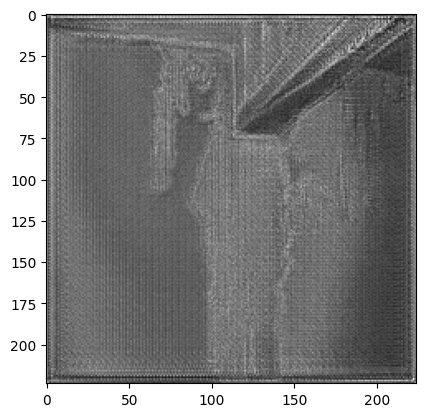

In [50]:
img_array = img_tensor.detach().numpy().squeeze()

plt.imshow(img_array, cmap='gray')
plt.show()
